# Text Analysis: NLP (Sentiment Analysis, Topic Modeling, Visualizations)
This notebook is the bulk of my NLP work on The Beatles in regards to sentiment analysis and topic modeling for The Beatles and each individual member.

In [1]:
# The usual suspects (and json)
import json
import numpy as np
import pandas as pd

# NLP libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import NMF
from nltk.tokenize import TweetTokenizer
from nltk import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.manifold import TSNE
import nltk

# Helper functions & Pipeline
from helper_functions.lyrics_cleaners import rep_linebrk, display_topics
from helper_functions.pipeline import NLPPipe

# Visualization packages
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import matplotlib.ticker as mtick
%matplotlib inline

import pickle
%load_ext autoreload
%autoreload 2

## NLP Pipeline

In [2]:
beatles = pd.read_pickle("Data/AllBeatlesProj.pkl")
# Load up the full The Beatles DataFrame

In [3]:
beatles = beatles[beatles['artist']=='The Beatles']
# Select only The Beatles' songs

In [4]:
beatles = beatles.reset_index()
beatles = beatles.drop_duplicates(subset='song_title').reset_index().drop(columns='index')
beatles['lyrics'] = beatles['lyrics'].apply(lambda x: rep_linebrk(x))
# Clean up the DataFrame for NLP

In [5]:
corpus_list = beatles['lyrics'].tolist()
# Create our corpus list for the Pipeline

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
add_these = ['oh','ve','ll','ooh','na','la','ca','wo','ah','yeah','oo','woad','well','doo','da','mm','mmm','uh','hey','go','know','like','see','get','got','one','way','could','make','thing','whoa','let','would','woo','love','yes','gonna','caus','come','want','though','say']
stopwords.extend(add_these)
# This list of stop words is the result of EDA

In [7]:
nlp = NLPPipe(vectorizer=TfidfVectorizer(stop_words=stopwords, max_df=0.80, min_df=10), 
              tokenizer=TweetTokenizer().tokenize, 
              stemmer=SnowballStemmer("english",ignore_stopwords=True))
# TF-IDF may be better for our dataset. It works better with sparse datasets

In [8]:
nlp.fit(corpus_list)
dtm_beatles = nlp.transform(corpus_list)
# Fit the corpus and transform the corpus

## Topic Modeling and Insights
### The Beatles

In [9]:
nmf_model = NMF(5, random_state=0)
doc_topic = nmf_model.fit_transform(dtm_beatles)
display_topics(nmf_model, nlp.vectorizer.get_feature_names(), 15)
# 0 - Desire, # 1 - Reality, # 2 - Relationships, # 3 - Home, # 4 - Fun
# Topics that came after some work


Topic  0
need, tell, right, never, think, feel, mind, word, pleas, look, day, noth, good, time, still

Topic  1
babi, man, said, littl, fine, think, work, tell, feel, everybodi, old, run, right, tri, nobodi

Topic  2
girl, mine, day, look, anoth, kind, good, pleas, littl, chang, give, everi, take, better, run

Topic  3
back, cri, home, sing, sky, wait, blue, heart, never, lone, world, round, keep, eye, sit

Topic  4
long, danc, time, sing, boy, day, wait, tear, mani, happi, stand, pleas, heart, ever, night


In [10]:
H = pd.DataFrame(doc_topic.round(5),
             index = corpus_list,
             columns = range(5))
# Define our Document-Topic matrix

In [11]:
beatles['song_topic'] = H.idxmax(axis=1).tolist()
beatles['song_topic'].value_counts()
# See how our songs fit into the categories
# Topic 0 seems to be the most 'generic' containing the majority of songs

0    79
3    37
2    23
4    22
1    17
Name: song_topic, dtype: int64

In [12]:
album_titles = beatles['album_title'].unique().tolist()
# I want to create a Album-Topic matrix to give insights into each album

In [13]:
topics = {}
for album in album_titles:
    topics[album]= beatles[beatles['album_title']==album]['song_topic'].value_counts()

In [14]:
topic_df = pd.DataFrame(topics).T.fillna(0)

In [15]:
dates = beatles[['album_title','release_date']].drop_duplicates()['release_date']

In [16]:
dates.reset_index(drop=True,inplace=True)

In [17]:
topic_df['release_date']=dates

In [18]:
for inx, date in enumerate(dates):
    topic_df.iloc[inx,5] = date

In [19]:
topic_df
# Now we have counts of the topics on each song on each album

,0,1,2,3,4,release_date
Revolver (UK),10.0,1.0,1.0,1.0,1.0,1966-08-05 00:00:00
Rubber Soul (UK),7.0,2.0,3.0,1.0,1.0,1965-12-03 00:00:00
Help! (UK),7.0,1.0,4.0,2.0,0.0,1965-08-06 00:00:00
Please Please Me,3.0,3.0,2.0,3.0,3.0,1963-03-22 00:00:00
With the Beatles,4.0,2.0,0.0,5.0,3.0,1963-11-22 00:00:00
A Hard Day’s Night (US),2.0,0.0,1.0,3.0,2.0,1964-06-26 00:00:00
Let It Be,5.0,1.0,3.0,2.0,1.0,1970-05-08 00:00:00
Magical Mystery Tour (US),4.0,1.0,0.0,3.0,2.0,1967-11-27 00:00:00
Beatles for Sale,5.0,4.0,2.0,2.0,1.0,1964-12-04 00:00:00
Sgt. Pepper’s Lonely Hearts Club Band,7.0,0.0,1.0,4.0,1.0,1967-05-26 00:00:00


In [20]:
topic_df['total_songs'] = topic_df.sum(axis=1)
# I want to turn the numbers into percentages, so here I created a total songs column

In [21]:
for topic in [0,1,2,3,4]:
    topic_df[str(topic) + 'perc'] = topic_df[topic]/topic_df['total_songs']
# Get those percentages

In [22]:
topic_df.reset_index(inplace=True)
topic_df.rename({'index':'album_title'},inplace=True)
topic_df.set_index('release_date',inplace=True)
# Change the index for plotting

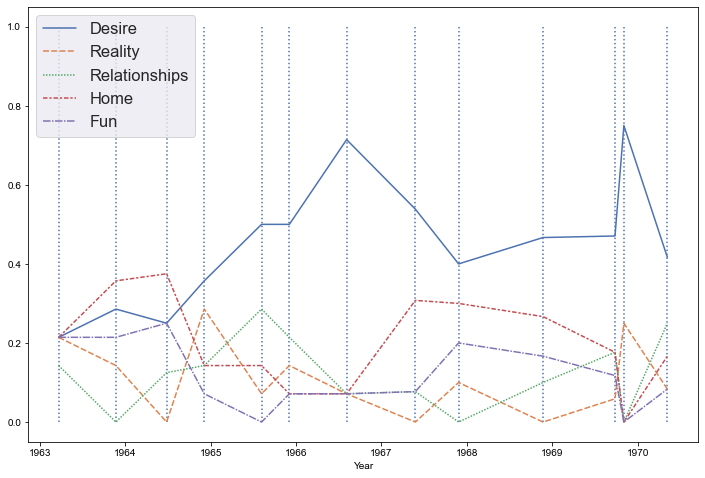

In [23]:
fig, ax = plt.subplots()
sns.set(font_scale=1.5)
fig.set_size_inches(12,8)
sns.lineplot(data=topic_df.iloc[:,7:12])
plt.vlines(x=topic_df.index.tolist(),ymin=0,ymax=1,ls=':')
plt.xlabel('Year')
plt.legend(['Desire','Reality','Relationships','Home','Fun'])
plt.savefig('beatles_topics.png');
# A little insight into our topics over time.

### Each Individual Beatle
Now we'll do the same process, but for each individual Beatle

In [24]:
singer_top = beatles[['song_title','release_date','singer','song_topic','album_title']]
# Now let's look into topics for each Beatle

In [25]:
harrison_top = singer_top[singer_top['singer']=='Harrison'].set_index('release_date')
starr_top = singer_top[singer_top['singer']=='Starr'].set_index('release_date')
mccartney_top = singer_top[singer_top['singer']=='McCartney'].set_index('release_date')
lennon_top = singer_top[singer_top['singer']=='Lennon'].set_index('release_date')

In [26]:
harr_counts = np.array(harrison_top['song_topic'].value_counts(sort=False).tolist())
harr_perc = harr_counts/harr_counts.sum()

In [27]:
starr_counts = np.array(starr_top['song_topic'].value_counts(sort=False).tolist())
starr_perc = starr_counts/starr_counts.sum()

In [28]:
mccar_counts = np.array(mccartney_top['song_topic'].value_counts(sort=False).tolist())
mccar_perc = mccar_counts/mccar_counts.sum()

In [29]:
lennon_counts = np.array(lennon_top['song_topic'].value_counts(sort=False).tolist())
lennon_perc = lennon_counts/lennon_counts.sum()

In [30]:
ind_topics = pd.DataFrame(data=[harr_perc,starr_perc,mccar_perc,lennon_perc],index=['Harrison','Starr','McCartney','Lennon'],columns=['Desire','Reality','Relationship','Home','Fun'])

In [31]:
ind_topics = ind_topics.reset_index().rename(columns={'index':'singer'})

In [32]:
ind_topics = pd.DataFrame(data=[harr_perc,starr_perc,mccar_perc,lennon_perc,],index=['Harrison','Starr','McCartney','Lennon'],columns=['Desire','Reality','Relationship','Home','Fun'])

In [33]:
color = ['#00C5B9','#F05768','#6611CC','#FD8E80']
# I want the color theme to match my Powerpoint

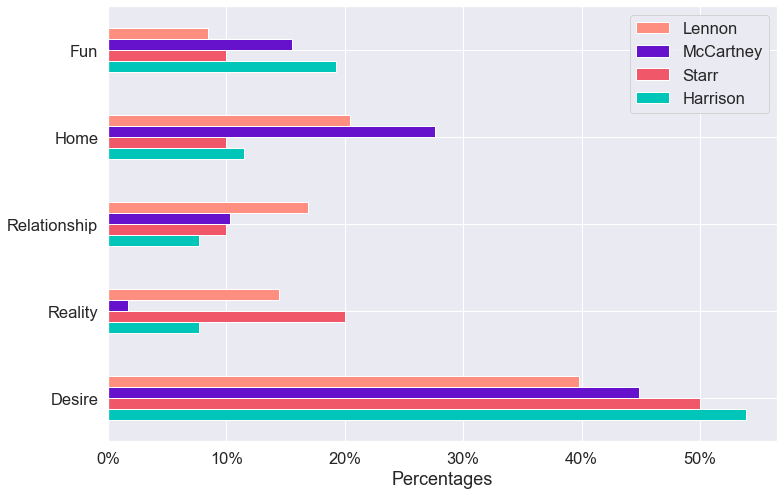

In [34]:
fig, ax = plt.subplots()
ind_topics.T.plot(kind='barh',figsize=(12,8),ax=ax,color=color)
handles,labels = ax.get_legend_handles_labels()
handles = [handles[3], handles[2], handles[1], handles[0]]
labels = [labels[3], labels[2], labels[1], labels[0]]
ax.legend(handles,labels)
plt.xlabel('Percentages')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.savefig('ind_topic2.png',transparent=True);

In [35]:
# color = ['#00C5B9','#F05768','#6611CC','#FD8E80'] #All colors
# color = ['#00C5B9','#D0D6E0','#D0D6E0','#D0D6E0'] #Lennon grey
# color = ['#D0D6E0','#F05768','#D0D6E0','#D0D6E0'] #McCartney grey
# color = ['#D0D6E0','#D0D6E0','#6611CC','#D0D6E0'] #Starr grey
color = ['#D0D6E0','#D0D6E0','#D0D6E0','#FD8E80'] #Harrison grey

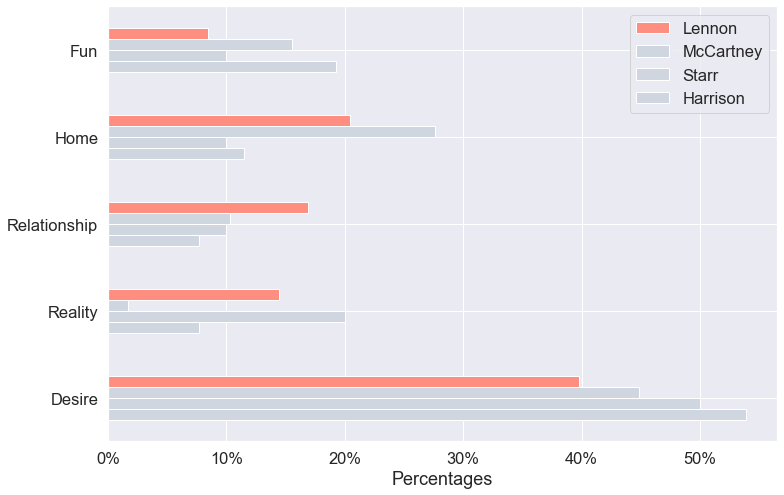

In [36]:
fig, ax = plt.subplots()
ind_topics.T.plot(kind='barh',figsize=(12,8),ax=ax,color=color)
handles,labels = ax.get_legend_handles_labels()
handles = [handles[3], handles[2], handles[1], handles[0]]
labels = [labels[3], labels[2], labels[1], labels[0]]
ax.legend(handles,labels)
plt.xlabel('Percentages')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
plt.savefig('lennon_topic.png',transparent=True);
# I reran this cell to save the plot for each Beatle

## Sentiment Analysis
### The Beatles

In [37]:
singer_top = singer_top.reset_index(level=0)

In [42]:
singer_top[singer_top['singer']!='"Instrumental"'].drop(labels=['index'],axis=1)
# There is one instrumental track in here I need to get rid of

,song_title,release_date,singer,song_topic,album_title
0,Taxman,1966-08-05 00:00:00,Harrison,0,Revolver (UK)
1,Eleanor Rigby,1966-08-05 00:00:00,McCartney,3,Revolver (UK)
2,I'm Only Sleeping,1966-08-05 00:00:00,Lennon,0,Revolver (UK)
3,Love You To,1966-08-05 00:00:00,Harrison,4,Revolver (UK)
4,"Here, There and Everywhere",1966-08-05 00:00:00,McCartney,0,Revolver (UK)
...,...,...,...,...,...
172,Revolution 1,1968-11-22 00:00:00,Lennon,0,The Beatles (The White Album)
173,Honey Pie,1968-11-22 00:00:00,McCartney,3,The Beatles (The White Album)
174,Savoy Truffle,1968-11-22 00:00:00,Harrison,0,The Beatles (The White Album)
175,Cry Baby Cry,1968-11-22 00:00:00,Lennon,3,The Beatles (The White Album)


In [43]:
album_titles

['Revolver (UK)',
 'Rubber Soul (UK)',
 'Help! (UK)',
 'Please Please Me',
 'With the Beatles',
 'A Hard Day’s Night (US)',
 'Let It Be',
 'Magical Mystery Tour (US)',
 'Beatles for Sale',
 'Sgt. Pepper’s Lonely Hearts Club Band',
 'Abbey Road',
 'Yellow Submarine',
 'The Beatles (The White Album)']

In [44]:
sid = SentimentIntensityAnalyzer()
# Set up the Sentiment Analyzer

In [45]:
song2 = beatles.lyrics[1]

In [46]:
beatles['sentiment'] = ''
# Set up a sentiment column

In [47]:
sdict = []
for inx, lyrics in enumerate(beatles.lyrics):
    ss = sid.polarity_scores(lyrics)
    ss['song_title'] = beatles.song_title[inx]
    sdict.append(ss)
# Get the sentiment for each song

In [48]:
beatles['sentiment'] = pd.DataFrame(sdict)['compound']

In [49]:
beatles.sort_values(by='sentiment').head(5)

,song_title,artist,album_title,release_date,lyrics,singer,song_topic,sentiment
153,The Continuing Story of Bungalow Bill,The Beatles,The Beatles (The White Album),1968-11-22 00:00:00,"Hey, Bungalow Bill What did you kill, Bungalow...",Lennon,3,-0.9979
132,I Want You (She's So Heavy),The Beatles,Abbey Road,1969-09-26 00:00:00,"I want you, I want you so bad I want you, I wa...",Lennon,0,-0.9966
77,Can't Buy Me Love,The Beatles,A Hard Day’s Night (US),1964-06-26 00:00:00,"Can't buy me love, love Can't buy me love I'll...",McCartney,0,-0.9931
68,Not a Second Time,The Beatles,With the Beatles,1963-11-22 00:00:00,You know you made me cry I see no use in wonde...,Lennon,3,-0.9930
34,Ticket to Ride,The Beatles,Help! (UK),1965-08-06 00:00:00,"I think I'm going to be sad, I think it's toda...",Lennon,1,-0.9919


In [50]:
beatles.sort_values(by='sentiment').tail(5)

,song_title,artist,album_title,release_date,lyrics,singer,song_topic,sentiment
142,The End,The Beatles,Abbey Road,1969-09-26 00:00:00,"Oh yeah, alright Are you going to be in my dre...",McCartney,0,0.9991
7,Good Day Sunshine,The Beatles,Revolver (UK),1966-08-05 00:00:00,Good day sunshine Good day sunshine Good day s...,McCartney,2,0.9991
49,Love Me Do,The Beatles,Please Please Me,1963-03-22 00:00:00,"Love, love me do You know I love you I'll alwa...",Lennon,0,0.9993
107,Eight Days a Week,The Beatles,Beatles for Sale,1964-12-04 00:00:00,"Ooh, I need your love, babe Guess you know it'...",Lennon,2,0.9994
99,All You Need Is Love,The Beatles,Magical Mystery Tour (US),1967-11-27 00:00:00,"Love, love, love Love, love, love Love, love, ...",Lennon,0,0.9998


In [51]:
beatles_sent = beatles.groupby(['album_title','release_date']).mean().reset_index(level=0)

In [52]:
beatles_sent.drop(labels='song_topic',axis=1,inplace=True)

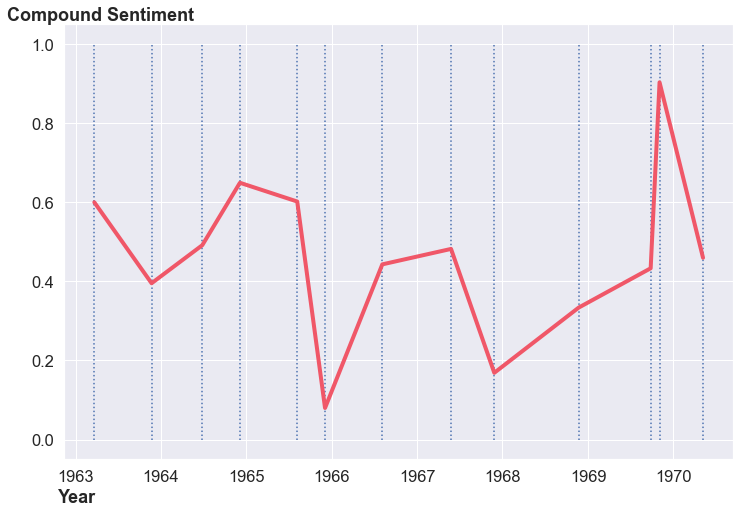

In [53]:
fig, ax = plt.subplots()
sns.set(font_scale=1.5)
fig.set_size_inches(12,8)
a = sns.color_palette(palette=['#F05768'])
sns.lineplot(data=beatles_sent,linewidth=4,palette=a)
plt.vlines(x=beatles_sent.index.tolist(),ymin=0,ymax=1,ls=':')
plt.xlabel('Year')
plt.ylabel('Compound Sentiment')
ax.get_legend().remove()
plt.ylabel('Compound Sentiment',y=1,fontweight="bold").set_rotation(0)
ax.yaxis.set_label_coords(0.055,1)
plt.xlabel('Year',x=0.020,fontweight="bold")
plt.savefig('beatles_sent.png',transparent=True);
# The Beatles tried to stay positive

### Each individual Beatle

In [54]:
sentiment = beatles.groupby(['album_title','singer','release_date']).mean()

In [55]:
sentiment = sentiment.drop(columns='song_topic')

In [56]:
sentiment.reset_index(level=[0,1],inplace=True)

In [57]:
sentiment = sentiment[sentiment['singer']!='"Instrumental"']

In [58]:
color = ['#00C5B9','#F05768','#6611CC','#FD8E80'] #All colors

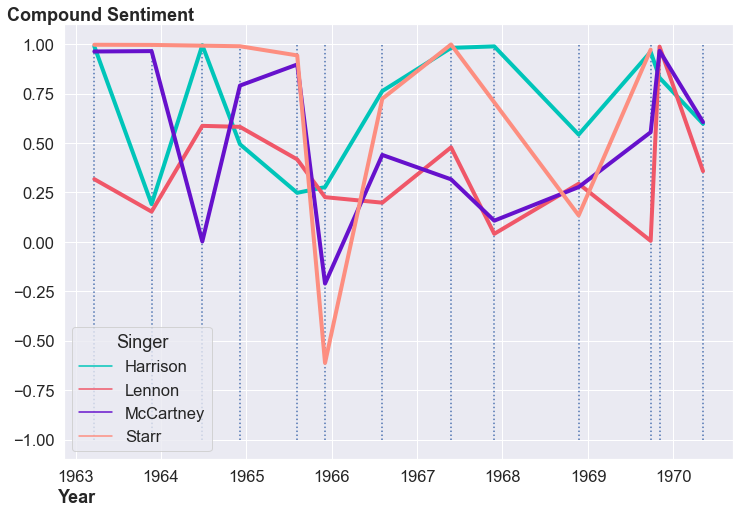

In [59]:
fig, ax = plt.subplots()
sns.lineplot(x='release_date',y='sentiment',data=sentiment,hue='singer',palette=color,linewidth=4)
fig.set_size_inches(12,8)
plt.vlines(x=beatles_sent.index.tolist(),ymin=-1,ymax=1,ls=':')
plt.xlabel('Year')
plt.ylabel('Compound Sentiment',y=1,fontweight="bold").set_rotation(0)
ax.yaxis.set_label_coords(0.055,1)
plt.xlabel('Year',x=0.020,fontweight="bold")
plt.ylabel('Compound Sentiment')
plt.legend(title='Singer')
plt.savefig('beatles_sent.png');

And that concludes our look into The Beatles